In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import os
import pickle as pkl
import glob
import itertools

#from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, FunctionTransformer
import category_encoders as ce

import da_func
#import data_preprocessing

%load_ext autoreload
%autoreload 2

In [2]:
루트경로 = '../'

데이터경로 = 루트경로 + 'data/'

In [3]:
train_df = pd.read_csv(데이터경로 + 'org/train.csv')
test_df = pd.read_csv(데이터경로 + 'org/test.csv')

In [4]:
print(train_df.shape)
train_df.head()

(600000, 25)


,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,...,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
0,0,0.0,0.0,0.0,F,N,Red,Trapezoid,Hamster,Russia,...,02e7c8990,3.0,Contributor,Hot,c,U,Pw,6.0,3.0,0
1,1,1.0,1.0,0.0,F,Y,Red,Star,Axolotl,NaN,...,f37df64af,3.0,Grandmaster,Warm,e,X,pE,7.0,7.0,0
2,2,0.0,1.0,0.0,F,N,Red,NaN,Hamster,Canada,...,NaN,3.0,NaN,Freezing,n,P,eN,5.0,9.0,0
3,3,NaN,0.0,0.0,F,N,Red,Circle,Hamster,Finland,...,f9d456e57,1.0,Novice,Lava Hot,a,C,NaN,3.0,3.0,0
4,4,0.0,NaN,0.0,T,N,Red,Triangle,Hamster,Costa Rica,...,c5361037c,3.0,Grandmaster,Cold,h,C,OZ,5.0,12.0,0


In [5]:
eqsample = pd.concat([train_df[train_df['target'] == 1].sample(n=100000), train_df[train_df['target'] == 0].sample(n=100000)])

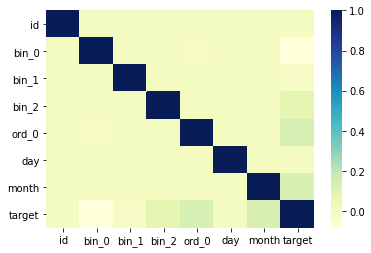

In [6]:
corr = eqsample.corr()
sns.heatmap(corr, cmap="YlGnBu")

In [7]:
print(test_df.shape)
test_df.head()

(400000, 24)


,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,...,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month
0,600000,0.0,0.0,0.0,F,Y,Blue,Polygon,Axolotl,Finland,...,ca9ad1d4b,fced9e114,3.0,Novice,Boiling Hot,f,U,oU,3.0,9.0
1,600001,0.0,0.0,0.0,F,Y,Red,Circle,Lion,Russia,...,060a21580,7ca8775da,1.0,Novice,Cold,n,N,NaN,2.0,8.0
2,600002,0.0,0.0,0.0,F,Y,Blue,Circle,Axolotl,Russia,...,165e81a00,5940334c9,1.0,Expert,Warm,i,N,DN,2.0,6.0
3,600003,1.0,0.0,0.0,F,N,Red,Polygon,Axolotl,Costa Rica,...,77d41330d,6fbdeefc8,1.0,Expert,Hot,m,B,AG,1.0,6.0
4,600004,0.0,0.0,1.0,F,Y,Red,Circle,NaN,Finland,...,2218d9dfe,2a27c8fde,1.0,Contributor,Lava Hot,o,J,DT,3.0,3.0


In [8]:
all_data = dict()

encoders = dict()

---
### 컬럼별 전환
#### bin 컬럼 전환

In [9]:
bin_cols = train_df.columns[train_df.columns.str.contains('bin')]
print(bin_cols)
train_df.loc[:, bin_cols]

Index(['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4'], dtype='object')


,bin_0,bin_1,bin_2,bin_3,bin_4
0,0.0,0.0,0.0,F,N
1,1.0,1.0,0.0,F,Y
2,0.0,1.0,0.0,F,N
3,NaN,0.0,0.0,F,N
4,0.0,NaN,0.0,T,N
...,...,...,...,...,...
599995,0.0,1.0,0.0,T,N
599996,1.0,0.0,0.0,T,Y
599997,0.0,0.0,0.0,F,Y
599998,1.0,1.0,0.0,F,Y


1. 0값으로 채우기
2. -1값으로 채우기
3. One Hot Encoding

In [10]:
def bin_encoding_0(df):
    bin_cols = ['bin_%d' % x for x in range(0, 5)]
    bin0 = df.loc[:, bin_cols].copy()

    bin0.loc[bin0['bin_3'] == 'F', 'bin_3'] = 0.
    bin0.loc[bin0['bin_3'] == 'T', 'bin_3'] = 1.

    bin0.loc[bin0['bin_4'] == 'N', 'bin_4'] = 0.
    bin0.loc[bin0['bin_4'] == 'Y', 'bin_4'] = 1.

    bin0 = bin0.fillna(0.)

    return bin0


def bin_encoding_99(df):
    bin_cols = ['bin_%d' % x for x in range(0, 5)]
    bin0 = df.loc[:, bin_cols].copy()

    bin0.loc[bin0['bin_3'] == 'F', 'bin_3'] = 0.
    bin0.loc[bin0['bin_3'] == 'T', 'bin_3'] = 1.

    bin0.loc[bin0['bin_4'] == 'N', 'bin_4'] = 0.
    bin0.loc[bin0['bin_4'] == 'Y', 'bin_4'] = 1.

    bin0 = bin0.fillna(-99.)

    return bin0

In [11]:
all_data['bin'] = {
    "bin0": bin_encoding_0,
    "binn99": bin_encoding_99
}

---
#### nominal 컬럼 전환
##### nom_0~4 : low cardinality

In [12]:
nom_cols = train_df.columns[train_df.columns.str.contains('nom')]
nom_l = nom_cols[:5]
nom_h = nom_cols[5:]
print(nom_l)
display(train_df.loc[:, nom_l])

Index(['nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4'], dtype='object')


,nom_0,nom_1,nom_2,nom_3,nom_4
0,Red,Trapezoid,Hamster,Russia,Bassoon
1,Red,Star,Axolotl,NaN,Theremin
2,Red,NaN,Hamster,Canada,Bassoon
3,Red,Circle,Hamster,Finland,Theremin
4,Red,Triangle,Hamster,Costa Rica,NaN
...,...,...,...,...,...
599995,Red,Polygon,Axolotl,India,Theremin
599996,Blue,Polygon,Dog,Costa Rica,Oboe
599997,Red,Circle,Axolotl,Russia,Theremin
599998,NaN,Polygon,Axolotl,NaN,Piano


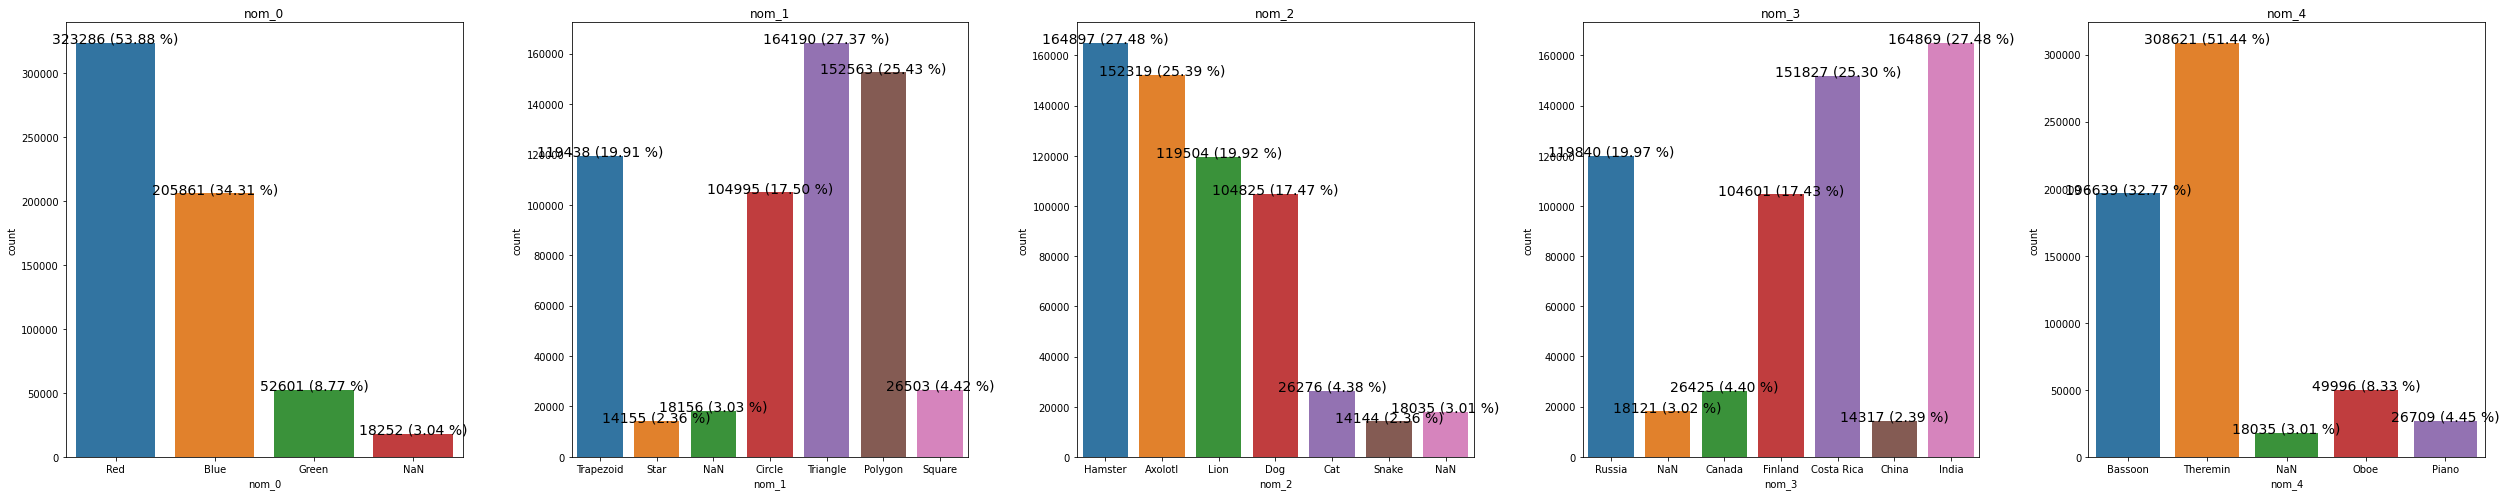

In [16]:
da_func.countplot_cols(train_df, nom_l, ncols=5, dropna=False)

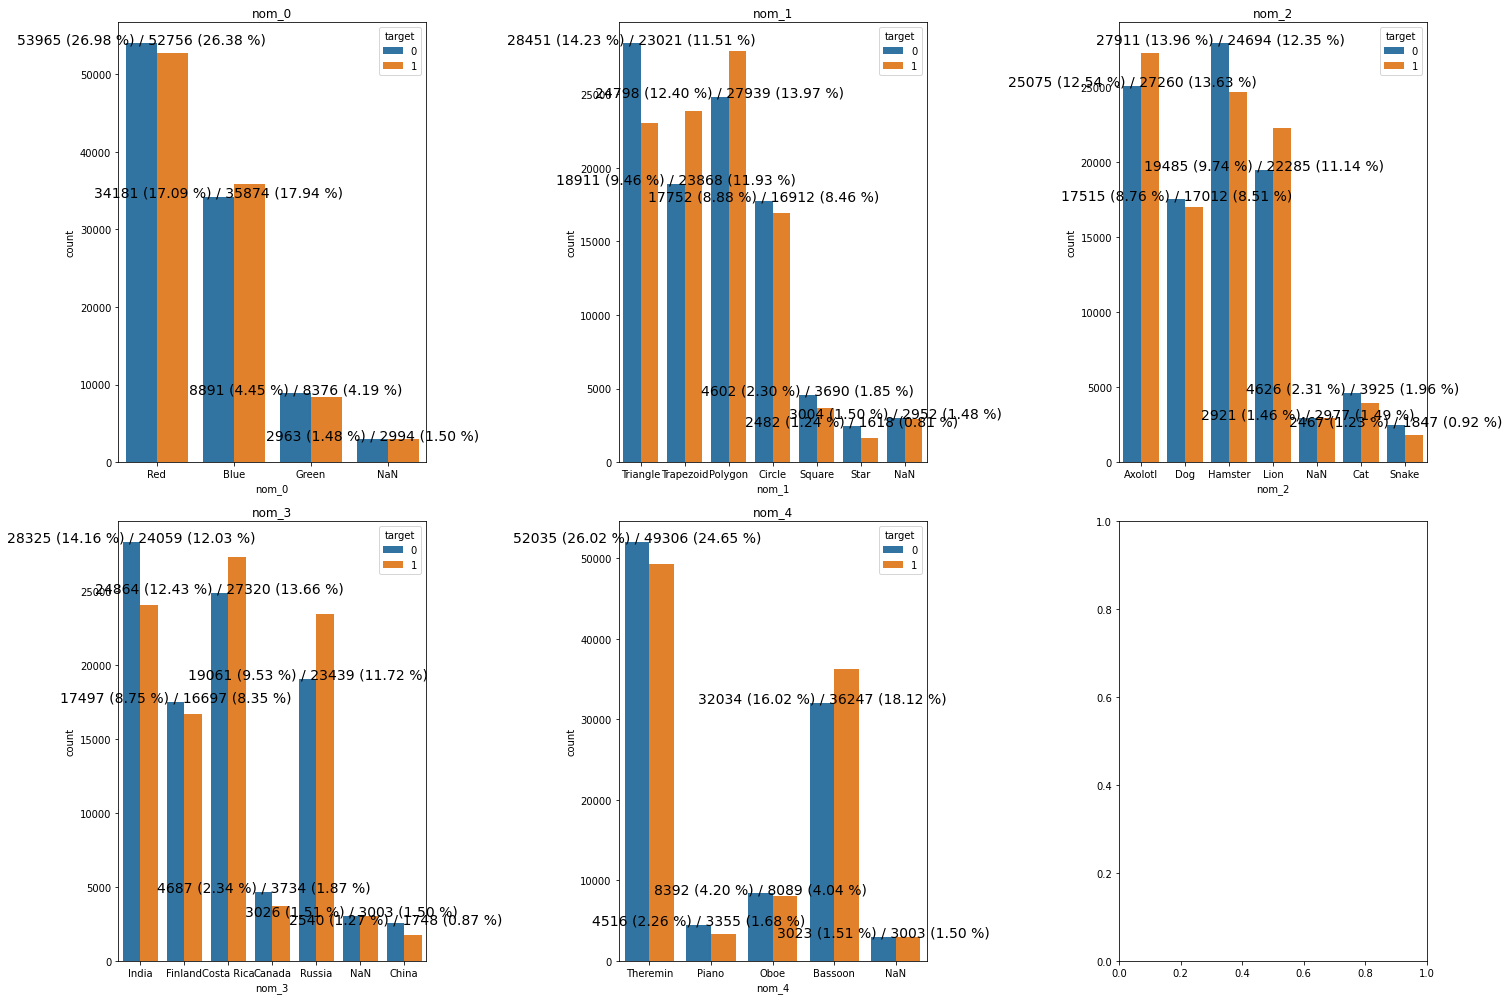

In [17]:
da_func.countplot_cols(eqsample, nom_l, hue='target', ncols=3, dropna=False)

1. one-hot encoding
 - 전체 다 one hot
 - 비중 높은 것만/significant 한 것만 남기기?
2. leave-one-out encoding

In [13]:
nom_l = ['nom_%d' % x for x in range(0, 5)]

nom_oh = train_df.loc[:, nom_l].copy()
nom_oh = nom_oh.fillna('NaN')

encoders['nom_l_ohe'] = dict()
for c in nom_oh.columns:
    ohe = OneHotEncoder(sparse=False)
    ohe_t = pd.DataFrame(ohe.fit_transform(nom_oh[[c]]))
    ohe_t.columns = ['%s_%s' % (c, d) for d in list(ohe.categories_)[0]]
    nom_oh = pd.concat([nom_oh, ohe_t], axis=1)
    encoders['nom_l_ohe'][c] = ohe
nom_oh = nom_oh.iloc[:, 5:]
nom_oh = nom_oh.loc[:, nom_oh.columns.str.contains('NaN') == False]

nom_oh

,nom_0_Blue,nom_0_Green,nom_0_Red,nom_1_Circle,nom_1_Polygon,nom_1_Square,nom_1_Star,nom_1_Trapezoid,nom_1_Triangle,nom_2_Axolotl,...,nom_3_Canada,nom_3_China,nom_3_Costa Rica,nom_3_Finland,nom_3_India,nom_3_Russia,nom_4_Bassoon,nom_4_Oboe,nom_4_Piano,nom_4_Theremin
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599995,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
599996,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
599997,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
599998,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [14]:
encoders['nom_l_ohe']

{'nom_0': OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
               handle_unknown='error', sparse=False),
 'nom_1': OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
               handle_unknown='error', sparse=False),
 'nom_2': OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
               handle_unknown='error', sparse=False),
 'nom_3': OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
               handle_unknown='error', sparse=False),
 'nom_4': OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
               handle_unknown='error', sparse=False)}

In [55]:
def nom_l_oh_encoding(df):
    nom_l = ['nom_%d' % x for x in range(0, 5)]
    
    nom_oh = df.loc[:, nom_l].copy()
    nom_oh = nom_oh.fillna('NaN')
    
    nom_l_ohe = encoders['nom_l_ohe']
    
    for k, enc in nom_l_ohe.items():
        ohe_k = pd.DataFrame(enc.transform(nom_oh[[k]]))
        ohe_k.columns = ['%s_%s' % (k, d) for d in list(enc.categories_)[0]]
        nom_oh = pd.concat([nom_oh, ohe_k], axis=1)

    nom_oh = nom_oh.iloc[:, 5:]
    nom_oh = nom_oh.loc[:, nom_oh.columns.str.contains('NaN') == False]
    return nom_oh

# def nom_l_oh_encoding_sig(df):
#     nom_oh = nom_l_ohe(df)
#     nom_oh = nom_oh[['nom_1_Trapezoid', 'nom_1_Triangle', 'nom_1_Polygon',
#                      'nom_2_Hamster', 'nom_2_Axolotl', 'nom_2_Lion',
#                      'nom_3_Costa Rica', 'nom_3_Russia', 'nom_3_India', 
#                      'nom_4_Bassoon', 'nom_4_Theremin']]
#     return nom_oh

In [57]:
nom_l_oh_encoding(train_df)

,nom_0_Blue,nom_0_Green,nom_0_Red,nom_1_Circle,nom_1_Polygon,nom_1_Square,nom_1_Star,nom_1_Trapezoid,nom_1_Triangle,nom_2_Axolotl,...,nom_3_Canada,nom_3_China,nom_3_Costa Rica,nom_3_Finland,nom_3_India,nom_3_Russia,nom_4_Bassoon,nom_4_Oboe,nom_4_Piano,nom_4_Theremin
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599995,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
599996,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
599997,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
599998,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [56]:
nl_loo = ce.leave_one_out.LeaveOneOutEncoder(verbose=1, random_state=42)
nom_l_loo = nl_loo.fit_transform(train_df.loc[:, nom_l], train_df['target'])
nom_l_loo

,nom_0,nom_1,nom_2,nom_3,nom_4
0,0.183068,0.225466,0.168015,0.219536,0.207376
1,0.183068,0.130211,0.201106,0.185872,0.179574
2,0.183068,0.182815,0.168015,0.159855,0.207376
3,0.183068,0.179696,0.168015,0.178948,0.179574
4,0.183068,0.157361,0.168015,0.202837,0.185538
...,...,...,...,...,...
599995,0.183068,0.205418,0.201106,0.163367,0.179574
599996,0.195764,0.205418,0.181886,0.202837,0.180638
599997,0.183068,0.179696,0.201106,0.219536,0.179574
599998,0.185305,0.205418,0.201106,0.185872,0.140332


In [17]:
encoders['nom_l_loo'] = nl_loo

In [18]:
def nom_l_loo_encoding(df):
    nom_l = ['nom_%d' % x for x in range(0, 5)]
    nom_loo = df.loc[:, nom_l].copy()
    
    y = None
    if 'target' in df.columns:
        y = df['target']
    return encoders['nom_l_loo'].transform(nom_loo, y=y)

In [19]:
nom_l_loo_encoding(train_df)

,nom_0,nom_1,nom_2,nom_3,nom_4
0,0.183068,0.225466,0.168015,0.219536,0.207376
1,0.183068,0.130211,0.201106,0.185872,0.179574
2,0.183068,0.182815,0.168015,0.159855,0.207376
3,0.183068,0.179696,0.168015,0.178948,0.179574
4,0.183068,0.157361,0.168015,0.202837,0.185538
...,...,...,...,...,...
599995,0.183068,0.205418,0.201106,0.163367,0.179574
599996,0.195764,0.205418,0.181886,0.202837,0.180638
599997,0.183068,0.179696,0.201106,0.219536,0.179574
599998,0.185305,0.205418,0.201106,0.185872,0.140332


In [59]:
all_data['nom_l'] = {
    'nlohe': nom_l_oh_encoding,
    #nom_l_oh_encoding_sig,
    'nlloo' : nom_l_loo_encoding
}

##### nom_5~9 : high cardinality

In [21]:
print(nom_h)
display(train_df.loc[:, nom_h])

Index(['nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9'], dtype='object')


,nom_5,nom_6,nom_7,nom_8,nom_9
0,de4c57ee2,a64bc7ddf,598080a91,0256c7a4b,02e7c8990
1,2bb3c3e5c,3a3a936e8,1dddb8473,52ead350c,f37df64af
2,b574c9841,708248125,5ddc9a726,745b909d1,NaN
3,673bdf1f6,23edb8da3,3a33ef960,bdaa56dd1,f9d456e57
4,777d1ac2c,3a7975e46,bc9cc2a94,NaN,c5361037c
...,...,...,...,...,...
599995,014770cf0,da5014b01,a7059911d,158183c63,015c63324
599996,NaN,2023ed4ed,83bdea3a5,e9fde8fa8,a02ae6a63
599997,c7dc5d460,5d7d341ac,114b1dbf3,cccbca824,40f9610c1
599998,4d7780407,209e1054e,fba315672,4164322bd,c1a8374a0


1. 16진수 -> 10진수 인코딩 (사실 무언가의 세션 넘버 같아보이긴 하지만... 일단은 16진수는 맞는 것 같으니)
2. leave one out encoding

In [22]:
def nom_h_16_encoding(df):
    nom_h = ['nom_%d' % x for x in range(5, 10)]
    nom_h_16 = df.loc[:, nom_h].copy()
    nom_h_16 = nom_h_16.fillna('000000000')
    for c in nom_h:
        nom_h_16[c] = nom_h_16[c].apply(lambda x: int(x, 16))
    nom_h_16 = nom_h_16 / int('fffffffff', 16)
    return nom_h_16

In [23]:
nh16_df = nom_h_16_encoding(train_df)
nh16_df

,nom_5,nom_6,nom_7,nom_8,nom_9
0,0.868352,0.649594,0.349617,0.009137,0.011349
1,0.170712,0.227456,0.116664,0.323896,0.951141
2,0.708813,0.439488,0.366647,0.454522,0.000000
3,0.403257,0.140346,0.227355,0.740880,0.975896
4,0.466753,0.228416,0.736767,0.000000,0.770356
...,...,...,...,...,...
599995,0.004996,0.852784,0.652429,0.084007,0.005316
599996,0.000000,0.125548,0.514617,0.914031,0.625655
599997,0.780706,0.365192,0.067552,0.799985,0.253805
599998,0.302605,0.127412,0.982957,0.255435,0.756473


In [24]:
nh16_df / int('fffffffff', 16)

,nom_5,nom_6,nom_7,nom_8,nom_9
0,1.263619e-11,9.452834e-12,5.087598e-12,1.329558e-13,1.651531e-13
1,2.484183e-12,3.309925e-12,1.697691e-12,4.713302e-12,1.384092e-11
2,1.031459e-11,6.395391e-12,5.335422e-12,6.614168e-12,0.000000e+00
3,5.868166e-12,2.042305e-12,3.308450e-12,1.078123e-11,1.420116e-11
4,6.792146e-12,3.323888e-12,1.072137e-11,0.000000e+00,1.121016e-11
...,...,...,...,...,...
599995,7.270643e-14,1.240965e-11,9.494094e-12,1.222470e-12,7.735756e-14
599996,0.000000e+00,1.826967e-12,7.488657e-12,1.330090e-11,9.104473e-12
599997,1.136077e-11,5.314239e-12,9.830173e-13,1.164131e-11,3.693352e-12
599998,4.403478e-12,1.854087e-12,1.430391e-11,3.717070e-12,1.100813e-11


In [25]:
nom_h = ['nom_%d' % x for x in range(5, 10)]

nh_loo = ce.leave_one_out.LeaveOneOutEncoder(verbose=1, random_state=42)
nom_h_loo = nh_loo.fit_transform(train_df.loc[:, nom_h], train_df['target'])
nom_h_loo

,nom_5,nom_6,nom_7,nom_8,nom_9
0,0.210269,0.162393,0.103356,0.128589,0.165049
1,0.194030,0.201373,0.129039,0.197359,0.153119
2,0.181564,0.163934,0.262826,0.172647,0.187860
3,0.207705,0.203735,0.144243,0.224138,0.270270
4,0.153098,0.162698,0.195512,0.191788,0.250447
...,...,...,...,...,...
599995,0.146143,0.148036,0.215008,0.224975,0.156364
599996,0.181752,0.191781,0.196907,0.192840,0.156716
599997,0.189501,0.176471,0.220058,0.111185,0.203562
599998,0.206485,0.153693,0.261896,0.288805,0.181102


In [26]:
nh_loo.transform(train_df.loc[:, nom_h], train_df['target'])

,nom_5,nom_6,nom_7,nom_8,nom_9
0,0.210269,0.162393,0.103356,0.128589,0.165049
1,0.194030,0.201373,0.129039,0.197359,0.153119
2,0.181564,0.163934,0.262826,0.172647,0.187860
3,0.207705,0.203735,0.144243,0.224138,0.270270
4,0.153098,0.162698,0.195512,0.191788,0.250447
...,...,...,...,...,...
599995,0.146143,0.148036,0.215008,0.224975,0.156364
599996,0.181752,0.191781,0.196907,0.192840,0.156716
599997,0.189501,0.176471,0.220058,0.111185,0.203562
599998,0.206485,0.153693,0.261896,0.288805,0.181102


In [27]:
encoders['nom_h_loo'] = nh_loo

In [28]:
def nom_h_loo_encoding(df):
    nom_h = ['nom_%d' % x for x in range(5, 10)]
    nom_loo = df.loc[:, nom_h].copy()
    
    y = None
    if 'target' in df.columns:
        y = df['target']
    nom_loo = encoders['nom_h_loo'].transform(nom_loo, y=y)
    return nom_loo

In [29]:
nom_h_loo_encoding(test_df)

,nom_5,nom_6,nom_7,nom_8,nom_9
0,0.157827,0.151261,0.125761,0.182075,0.146751
1,0.155556,0.213166,0.175406,0.234127,0.191781
2,0.210823,0.174699,0.251001,0.144341,0.162252
3,0.241458,0.204947,0.184991,0.169082,0.173469
4,0.194495,0.153646,0.250290,0.121985,0.154574
...,...,...,...,...,...
399995,0.156010,0.196899,0.266209,0.111489,0.235294
399996,0.184314,0.162950,0.249258,0.210654,0.274194
399997,0.157825,0.198083,0.191509,0.217125,0.257085
399998,0.225092,0.168367,0.185106,0.134310,0.216578


In [30]:
all_data['nom_h'] = {
    'nh16' : nom_h_16_encoding,
    'nhloo' : nom_h_loo_encoding
}

---
#### ord 데이터 변환
##### low-cardinality ordinal data

In [31]:
ord_cols = train_df.columns[train_df.columns.str.contains('ord')]
ord_l = ord_cols[:3]
ord_h = ord_cols[3:]
print(ord_l)
display(train_df.loc[:, ord_l])

Index(['ord_0', 'ord_1', 'ord_2'], dtype='object')


,ord_0,ord_1,ord_2
0,3.0,Contributor,Hot
1,3.0,Grandmaster,Warm
2,3.0,NaN,Freezing
3,1.0,Novice,Lava Hot
4,3.0,Grandmaster,Cold
...,...,...,...
599995,3.0,Novice,Freezing
599996,2.0,Novice,Boiling Hot
599997,2.0,Contributor,Freezing
599998,1.0,Master,Warm


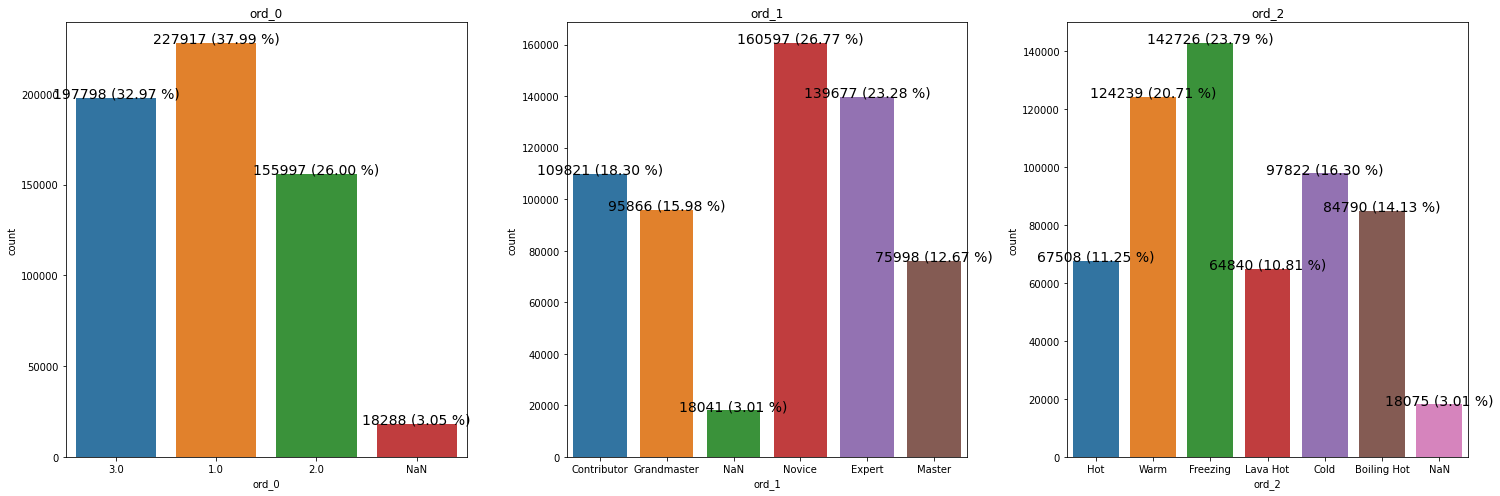

In [56]:
da_func.countplot_cols(train_df, ord_l, ncols=3, dropna=False)

ordinal
1. label encoding

In [32]:
ord_l_df = train_df.loc[:, ord_l].copy()
ord_l_df['ord_0'] = ord_l_df['ord_0'].fillna(0.)

ord_l_df['ord_1'] = ord_l_df['ord_1'].fillna('NaN')
le_ord_1 = OrdinalEncoder(categories=[['NaN', 'Novice', 'Contributor', 'Expert', 'Master', 'Grandmaster']])
ord_l_df['ord_1'] = le_ord_1.fit_transform(ord_l_df['ord_1'].values.reshape(-1, 1))

ord_l_df['ord_2'] = ord_l_df['ord_2'].fillna('NaN')
le_ord_2 = OrdinalEncoder(categories=[['Freezing', 'Cold', 'NaN', 'Warm', 'Hot', 'Boiling Hot', 'Lava Hot']])
ord_l_df['ord_2'] = le_ord_2.fit_transform(ord_l_df['ord_2'].values.reshape(-1, 1))

ord_l_df

,ord_0,ord_1,ord_2
0,3.0,2.0,4.0
1,3.0,5.0,3.0
2,3.0,0.0,0.0
3,1.0,1.0,6.0
4,3.0,5.0,1.0
...,...,...,...
599995,3.0,1.0,0.0
599996,2.0,1.0,5.0
599997,2.0,2.0,0.0
599998,1.0,4.0,3.0


In [33]:
encoders['ord_l'] = {'ord_1': le_ord_1, 'ord_2': le_ord_2}

In [34]:
def ord_l_encoding(df):
    ord_l = ['ord_%d' % x for x in range(0, 3)]
    ord_l_df = df.loc[:, ord_l].copy()
    
    ord_l_df['ord_0'] = ord_l_df['ord_0'].fillna(0.)

    for c, enc in encoders['ord_l'].items():
        ord_l_df[c] = ord_l_df[c].fillna('NaN')
        ord_l_df[c] = enc.transform(ord_l_df[c].values.reshape(-1, 1))

    return ord_l_df

In [35]:
all_data['ord_l'] = {'olle' : ord_l_encoding}

##### high-cardinality ordinal feature

In [36]:
print(ord_h)
display(train_df.loc[:, ord_h])

Index(['ord_3', 'ord_4', 'ord_5'], dtype='object')


,ord_3,ord_4,ord_5
0,c,U,Pw
1,e,X,pE
2,n,P,eN
3,a,C,NaN
4,h,C,OZ
...,...,...,...
599995,a,R,GZ
599996,n,N,sf
599997,n,H,MV
599998,m,X,Ey


In [62]:
train_df.loc[train_df['ord_3'].isna(), ord_h].index

Int64Index([    35,    100,    144,    251,    287,    335,    336,    341,
               342,    363,
            ...
            599629, 599664, 599669, 599791, 599833, 599849, 599917, 599958,
            599965, 599969],
           dtype='int64', length=17916)

cardinality가 높은 것도 높은 건데. 이게 순서가 의미가 있는 지 잘 모르겠다. 의미가 있는 순서대로의 클래스의 의미인지, 예를들어 라스트 네임의 이니셜을 따왔다거나 하는 의미 없는 순서인건지...

1. Leave One Out Encoding (잘 모르겠을땐 이거)
2. Label Encoding / ordinal encoding - 순서에 의미가 있다고 가정
  - ord_5같은 경우... 어쩌나? 대문자, 소문자 순서, 알파벳 순서... 앞글자 뒷글자 따로?

In [37]:
oh_loo = ce.leave_one_out.LeaveOneOutEncoder(verbose=1, random_state=42)
ord_h_loo = oh_loo.fit_transform(train_df.loc[:, ord_h], train_df['target'])
ord_h_loo

,ord_3,ord_4,ord_5
0,0.113526,0.222945,0.143639
1,0.135517,0.233754,0.236952
2,0.289387,0.201008,0.208805
3,0.091503,0.138987,0.184225
4,0.182086,0.138987,0.160167
...,...,...,...
599995,0.091503,0.207390,0.128109
599996,0.289387,0.187108,0.256899
599997,0.289387,0.162370,0.137202
599998,0.265993,0.233754,0.123257


In [38]:
encoders['ord_h_loo'] = oh_loo

In [39]:
def ord_h_loo_encoding(df):
    ord_h = ['ord_%d' % x for x in range(3, 6)]
    ord_loo = df.loc[:, ord_h].copy()
    
    y = None
    if 'target' in df.columns:
        y = df['target']
    return encoders['ord_h_loo'].transform(ord_loo, y=y)

In [40]:
ord_h_le = train_df.loc[:, ord_h].copy()
ord_h_le = ord_h_le.fillna('')

encoders['ord_h_le'] = dict()
for c in ord_h:
    le = LabelEncoder()
    ord_h_le[c] = le.fit_transform(ord_h_le[c])
    encoders['ord_h_le'][c] = le
ord_h_le

,ord_3,ord_4,ord_5
0,3,21,57
1,5,24,151
2,14,16,106
3,1,3,0
4,8,3,51
...,...,...,...
599995,1,18,23
599996,14,14,164
599997,14,8,43
599998,13,24,19


In [41]:
def ord_h_le_encoding(df):
    ord_h = ['ord_%d' % x for x in range(3, 6)]
    ord_h_le = df.loc[:, ord_h].copy()
    ord_h_le = ord_h_le.fillna('')
    
    encoders['ord_h_le']
    for c, enc in encoders['ord_h_le'].items():
        ord_h_le[c] = enc.transform(ord_h_le[c])

    return ord_h_le

In [42]:
all_data['ord_h'] = {
    'ohloo' : ord_h_loo_encoding,
    'ohle' : ord_h_le_encoding
}

---
#### Time Columns

In [43]:
time_c = ['day', 'month']
display(train_df[time_c])

,day,month
0,6.0,3.0
1,7.0,7.0
2,5.0,9.0
3,3.0,3.0
4,5.0,12.0
...,...,...
599995,5.0,NaN
599996,NaN,3.0
599997,7.0,5.0
599998,1.0,5.0


In [44]:
def time_label_encoding(df):
    time_c = ['day', 'month']
    time_df = df.loc[:, time_c].copy()
    time_df = time_df.fillna(0.)
    return time_df

def time_circular_encoding(df):
    time_c = ['day', 'month']
    time_df = df.loc[:, time_c].copy()

    for c in time_c:
        if c == 'day':
            max_val = 7
        elif c == 'month':
            max_val = 12
    
        time_df[c + '_sin'] = np.sin(2 * np.pi * time_df[c]/max_val)
        time_df[c + '_cos'] = np.cos(2 * np.pi * time_df[c]/max_val)
    
    time_df = time_df.fillna(0.)
    time_df = time_df.iloc[:, 2:]

    return time_df

In [45]:
all_data['time'] = {
    'tmle' : time_label_encoding,
    'tmce' : time_circular_encoding
}

In [46]:
display(time_label_encoding(train_df))
display(time_circular_encoding(train_df))

,day,month
0,6.0,3.0
1,7.0,7.0
2,5.0,9.0
3,3.0,3.0
4,5.0,12.0
...,...,...
599995,5.0,0.0
599996,0.0,3.0
599997,7.0,5.0
599998,1.0,5.0


,day_sin,day_cos,month_sin,month_cos
0,-7.818315e-01,0.623490,1.000000e+00,6.123234e-17
1,-2.449294e-16,1.000000,-5.000000e-01,-8.660254e-01
2,-9.749279e-01,-0.222521,-1.000000e+00,-1.836970e-16
3,4.338837e-01,-0.900969,1.000000e+00,6.123234e-17
4,-9.749279e-01,-0.222521,-2.449294e-16,1.000000e+00
...,...,...,...,...
599995,-9.749279e-01,-0.222521,0.000000e+00,0.000000e+00
599996,0.000000e+00,0.000000,1.000000e+00,6.123234e-17
599997,-2.449294e-16,1.000000,5.000000e-01,-8.660254e-01
599998,7.818315e-01,0.623490,5.000000e-01,-8.660254e-01


In [47]:
all_data

{'bin': {'bin0': <function __main__.bin_encoding_0(df)>,
  'binn99': <function __main__.bin_encoding_99(df)>},
 'nom_l': {'nlohe': <function __main__.nom_l_oh_encoding(df)>,
  'nlloo': <function __main__.nom_l_loo_encoding(df)>},
 'nom_h': {'nh16': <function __main__.nom_h_16_encoding(df)>,
  'nhloo': <function __main__.nom_h_loo_encoding(df)>},
 'ord_l': {'olle': <function __main__.ord_l_encoding(df)>},
 'ord_h': {'ohloo': <function __main__.ord_h_loo_encoding(df)>,
  'ohle': <function __main__.ord_h_le_encoding(df)>},
 'time': {'tmle': <function __main__.time_label_encoding(df)>,
  'tmce': <function __main__.time_circular_encoding(df)>}}

In [48]:
encoders.keys()

dict_keys(['nom_l_ohe', 'nom_l_loo', 'nom_h_loo', 'ord_l', 'ord_h_loo', 'ord_h_le'])

In [49]:
encoders

{'nom_l_ohe': {'nom_0': OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
                handle_unknown='error', sparse=False),
  'nom_1': OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
                handle_unknown='error', sparse=False),
  'nom_2': OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
                handle_unknown='error', sparse=False),
  'nom_3': OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
                handle_unknown='error', sparse=False),
  'nom_4': OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
                handle_unknown='error', sparse=False)},
 'nom_l_loo': LeaveOneOutEncoder(cols=['nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4'],
                    drop_invariant=False, handle_missing='value',
                    handle_unknown='value', random_state=42, return_df=True,
                    sigma=None, verbose=1),
 'nom_h_l

In [60]:
with open('../etc/encoders/encoders.pkl', 'wb') as f:
    pkl.dump(encoders, f)

In [61]:
with open('../etc/encoders/encoding_functions.pkl', 'wb') as f:
    pkl.dump(all_data, f)

In [52]:
for p in itertools.product([all_data[k] for k in all_data.keys()]):
    print(p)

({'bin0': <function bin_encoding_0 at 0x1094f94d0>, 'binn99': <function bin_encoding_99 at 0x1094f9680>},)
({'nlohe': <function nom_l_oh_encoding at 0x109502200>, 'nlloo': <function nom_l_loo_encoding at 0x1094f9200>},)
({'nh16': <function nom_h_16_encoding at 0x1a1ec6c830>, 'nhloo': <function nom_h_loo_encoding at 0x1a1ebed950>},)
({'olle': <function ord_l_encoding at 0x1a1f394a70>},)
({'ohloo': <function ord_h_loo_encoding at 0x1094f98c0>, 'ohle': <function ord_h_le_encoding at 0x1a1ec6cd40>},)
({'tmle': <function time_label_encoding at 0x1a1ec97320>, 'tmce': <function time_circular_encoding at 0x1a1ec97e60>},)


---
### 모든 조합으로 인코딩된 파일들 생성 (32개)

In [53]:
print(all_data.keys())

train_id = train_df.loc[:, ['id', 'target']].copy()
test_id = test_df.loc[:, ['id']].copy()

dict_keys(['bin', 'nom_l', 'nom_h', 'ord_l', 'ord_h', 'time'])


In [62]:
for element in itertools.product(*all_data.values()):
    print(element)
    
    filename = ''
    
    new_train = train_id.copy()
    new_test = test_id.copy()
    
    for i, c in enumerate(all_data.keys()):
        tr_tmp = all_data[c][element[i]](train_df)
        ts_tmp = all_data[c][element[i]](test_df)
        
        new_train = pd.concat([new_train, tr_tmp], axis=1)
        new_test = pd.concat([new_test, ts_tmp], axis=1)
        
        filename = filename + '_' + element[i]

    filepath = 데이터경로 + 'encoded/' + filename[1:] + '/'
    os.mkdir(filepath)
    new_train.to_csv(filepath + 'train.csv', index=False)
    #new_train.to_pickle(filepath + 'train.pkl')
    
    new_test.to_csv(filepath + 'test.csv', index=False)
    #new_test.to_pickle(filepath + 'test.pkl')
    
    display(new_test.head())

('bin0', 'nlohe', 'nh16', 'olle', 'ohloo', 'tmle')


,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0_Blue,nom_0_Green,nom_0_Red,nom_1_Circle,...,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month
0,600000,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.791425,0.988001,3.0,1.0,5.0,0.151036,0.222938,0.235641,3.0,9.0
1,600001,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.023592,0.486946,1.0,1.0,1.0,0.289383,0.187103,0.184215,2.0,8.0
2,600002,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.087380,0.348636,1.0,3.0,3.0,0.196071,0.187103,0.125748,2.0,6.0
3,600003,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.468080,0.436492,1.0,3.0,4.0,0.265988,0.135848,0.108688,1.0,6.0
4,600004,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.133192,0.164670,1.0,2.0,6.0,0.309608,0.175385,0.119081,3.0,3.0


('bin0', 'nlohe', 'nh16', 'olle', 'ohloo', 'tmce')


,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0_Blue,nom_0_Green,nom_0_Red,nom_1_Circle,...,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day_sin,day_cos,month_sin,month_cos
0,600000,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,3.0,1.0,5.0,0.151036,0.222938,0.235641,0.433884,-0.900969,-1.000000e+00,-1.836970e-16
1,600001,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,1.0,1.0,1.0,0.289383,0.187103,0.184215,0.974928,-0.222521,-8.660254e-01,-5.000000e-01
2,600002,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,1.0,3.0,3.0,0.196071,0.187103,0.125748,0.974928,-0.222521,1.224647e-16,-1.000000e+00
3,600003,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,3.0,4.0,0.265988,0.135848,0.108688,0.781831,0.623490,1.224647e-16,-1.000000e+00
4,600004,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,1.0,2.0,6.0,0.309608,0.175385,0.119081,0.433884,-0.900969,1.000000e+00,6.123234e-17


('bin0', 'nlohe', 'nh16', 'olle', 'ohle', 'tmle')


,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0_Blue,nom_0_Green,nom_0_Red,nom_1_Circle,...,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month
0,600000,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.791425,0.988001,3.0,1.0,5.0,6,21,147,3.0,9.0
1,600001,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.023592,0.486946,1.0,1.0,1.0,14,14,0,2.0,8.0
2,600002,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.087380,0.348636,1.0,3.0,3.0,9,14,13,2.0,6.0
3,600003,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.468080,0.436492,1.0,3.0,4.0,13,2,1,1.0,6.0
4,600004,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.133192,0.164670,1.0,2.0,6.0,15,10,15,3.0,3.0


('bin0', 'nlohe', 'nh16', 'olle', 'ohle', 'tmce')


,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0_Blue,nom_0_Green,nom_0_Red,nom_1_Circle,...,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day_sin,day_cos,month_sin,month_cos
0,600000,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,3.0,1.0,5.0,6,21,147,0.433884,-0.900969,-1.000000e+00,-1.836970e-16
1,600001,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,1.0,1.0,1.0,14,14,0,0.974928,-0.222521,-8.660254e-01,-5.000000e-01
2,600002,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,1.0,3.0,3.0,9,14,13,0.974928,-0.222521,1.224647e-16,-1.000000e+00
3,600003,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,3.0,4.0,13,2,1,0.781831,0.623490,1.224647e-16,-1.000000e+00
4,600004,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,1.0,2.0,6.0,15,10,15,0.433884,-0.900969,1.000000e+00,6.123234e-17


('bin0', 'nlohe', 'nhloo', 'olle', 'ohloo', 'tmle')


,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0_Blue,nom_0_Green,nom_0_Red,nom_1_Circle,...,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month
0,600000,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.182075,0.146751,3.0,1.0,5.0,0.151036,0.222938,0.235641,3.0,9.0
1,600001,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.234127,0.191781,1.0,1.0,1.0,0.289383,0.187103,0.184215,2.0,8.0
2,600002,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.144341,0.162252,1.0,3.0,3.0,0.196071,0.187103,0.125748,2.0,6.0
3,600003,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.169082,0.173469,1.0,3.0,4.0,0.265988,0.135848,0.108688,1.0,6.0
4,600004,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.121985,0.154574,1.0,2.0,6.0,0.309608,0.175385,0.119081,3.0,3.0


('bin0', 'nlohe', 'nhloo', 'olle', 'ohloo', 'tmce')


,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0_Blue,nom_0_Green,nom_0_Red,nom_1_Circle,...,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day_sin,day_cos,month_sin,month_cos
0,600000,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,3.0,1.0,5.0,0.151036,0.222938,0.235641,0.433884,-0.900969,-1.000000e+00,-1.836970e-16
1,600001,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,1.0,1.0,1.0,0.289383,0.187103,0.184215,0.974928,-0.222521,-8.660254e-01,-5.000000e-01
2,600002,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,1.0,3.0,3.0,0.196071,0.187103,0.125748,0.974928,-0.222521,1.224647e-16,-1.000000e+00
3,600003,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,3.0,4.0,0.265988,0.135848,0.108688,0.781831,0.623490,1.224647e-16,-1.000000e+00
4,600004,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,1.0,2.0,6.0,0.309608,0.175385,0.119081,0.433884,-0.900969,1.000000e+00,6.123234e-17


('bin0', 'nlohe', 'nhloo', 'olle', 'ohle', 'tmle')


,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0_Blue,nom_0_Green,nom_0_Red,nom_1_Circle,...,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month
0,600000,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.182075,0.146751,3.0,1.0,5.0,6,21,147,3.0,9.0
1,600001,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.234127,0.191781,1.0,1.0,1.0,14,14,0,2.0,8.0
2,600002,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.144341,0.162252,1.0,3.0,3.0,9,14,13,2.0,6.0
3,600003,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.169082,0.173469,1.0,3.0,4.0,13,2,1,1.0,6.0
4,600004,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.121985,0.154574,1.0,2.0,6.0,15,10,15,3.0,3.0


('bin0', 'nlohe', 'nhloo', 'olle', 'ohle', 'tmce')


,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0_Blue,nom_0_Green,nom_0_Red,nom_1_Circle,...,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day_sin,day_cos,month_sin,month_cos
0,600000,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,3.0,1.0,5.0,6,21,147,0.433884,-0.900969,-1.000000e+00,-1.836970e-16
1,600001,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,1.0,1.0,1.0,14,14,0,0.974928,-0.222521,-8.660254e-01,-5.000000e-01
2,600002,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,1.0,3.0,3.0,9,14,13,0.974928,-0.222521,1.224647e-16,-1.000000e+00
3,600003,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,3.0,4.0,13,2,1,0.781831,0.623490,1.224647e-16,-1.000000e+00
4,600004,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,1.0,2.0,6.0,15,10,15,0.433884,-0.900969,1.000000e+00,6.123234e-17


('bin0', 'nlloo', 'nh16', 'olle', 'ohloo', 'tmle')


,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,...,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month
0,600000,0.0,0.0,0.0,0.0,1.0,0.195763,0.205417,0.201104,0.178947,...,0.791425,0.988001,3.0,1.0,5.0,0.151036,0.222938,0.235641,3.0,9.0
1,600001,0.0,0.0,0.0,0.0,1.0,0.183067,0.179694,0.209834,0.219534,...,0.023592,0.486946,1.0,1.0,1.0,0.289383,0.187103,0.184215,2.0,8.0
2,600002,0.0,0.0,0.0,0.0,1.0,0.195763,0.179694,0.201104,0.219534,...,0.087380,0.348636,1.0,3.0,3.0,0.196071,0.187103,0.125748,2.0,6.0
3,600003,1.0,0.0,0.0,0.0,0.0,0.183067,0.205417,0.201104,0.202836,...,0.468080,0.436492,1.0,3.0,4.0,0.265988,0.135848,0.108688,1.0,6.0
4,600004,0.0,0.0,1.0,0.0,1.0,0.183067,0.179694,0.186582,0.178947,...,0.133192,0.164670,1.0,2.0,6.0,0.309608,0.175385,0.119081,3.0,3.0


('bin0', 'nlloo', 'nh16', 'olle', 'ohloo', 'tmce')


,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,...,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day_sin,day_cos,month_sin,month_cos
0,600000,0.0,0.0,0.0,0.0,1.0,0.195763,0.205417,0.201104,0.178947,...,3.0,1.0,5.0,0.151036,0.222938,0.235641,0.433884,-0.900969,-1.000000e+00,-1.836970e-16
1,600001,0.0,0.0,0.0,0.0,1.0,0.183067,0.179694,0.209834,0.219534,...,1.0,1.0,1.0,0.289383,0.187103,0.184215,0.974928,-0.222521,-8.660254e-01,-5.000000e-01
2,600002,0.0,0.0,0.0,0.0,1.0,0.195763,0.179694,0.201104,0.219534,...,1.0,3.0,3.0,0.196071,0.187103,0.125748,0.974928,-0.222521,1.224647e-16,-1.000000e+00
3,600003,1.0,0.0,0.0,0.0,0.0,0.183067,0.205417,0.201104,0.202836,...,1.0,3.0,4.0,0.265988,0.135848,0.108688,0.781831,0.623490,1.224647e-16,-1.000000e+00
4,600004,0.0,0.0,1.0,0.0,1.0,0.183067,0.179694,0.186582,0.178947,...,1.0,2.0,6.0,0.309608,0.175385,0.119081,0.433884,-0.900969,1.000000e+00,6.123234e-17


('bin0', 'nlloo', 'nh16', 'olle', 'ohle', 'tmle')


,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,...,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month
0,600000,0.0,0.0,0.0,0.0,1.0,0.195763,0.205417,0.201104,0.178947,...,0.791425,0.988001,3.0,1.0,5.0,6,21,147,3.0,9.0
1,600001,0.0,0.0,0.0,0.0,1.0,0.183067,0.179694,0.209834,0.219534,...,0.023592,0.486946,1.0,1.0,1.0,14,14,0,2.0,8.0
2,600002,0.0,0.0,0.0,0.0,1.0,0.195763,0.179694,0.201104,0.219534,...,0.087380,0.348636,1.0,3.0,3.0,9,14,13,2.0,6.0
3,600003,1.0,0.0,0.0,0.0,0.0,0.183067,0.205417,0.201104,0.202836,...,0.468080,0.436492,1.0,3.0,4.0,13,2,1,1.0,6.0
4,600004,0.0,0.0,1.0,0.0,1.0,0.183067,0.179694,0.186582,0.178947,...,0.133192,0.164670,1.0,2.0,6.0,15,10,15,3.0,3.0


('bin0', 'nlloo', 'nh16', 'olle', 'ohle', 'tmce')


,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,...,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day_sin,day_cos,month_sin,month_cos
0,600000,0.0,0.0,0.0,0.0,1.0,0.195763,0.205417,0.201104,0.178947,...,3.0,1.0,5.0,6,21,147,0.433884,-0.900969,-1.000000e+00,-1.836970e-16
1,600001,0.0,0.0,0.0,0.0,1.0,0.183067,0.179694,0.209834,0.219534,...,1.0,1.0,1.0,14,14,0,0.974928,-0.222521,-8.660254e-01,-5.000000e-01
2,600002,0.0,0.0,0.0,0.0,1.0,0.195763,0.179694,0.201104,0.219534,...,1.0,3.0,3.0,9,14,13,0.974928,-0.222521,1.224647e-16,-1.000000e+00
3,600003,1.0,0.0,0.0,0.0,0.0,0.183067,0.205417,0.201104,0.202836,...,1.0,3.0,4.0,13,2,1,0.781831,0.623490,1.224647e-16,-1.000000e+00
4,600004,0.0,0.0,1.0,0.0,1.0,0.183067,0.179694,0.186582,0.178947,...,1.0,2.0,6.0,15,10,15,0.433884,-0.900969,1.000000e+00,6.123234e-17


('bin0', 'nlloo', 'nhloo', 'olle', 'ohloo', 'tmle')


,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,...,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month
0,600000,0.0,0.0,0.0,0.0,1.0,0.195763,0.205417,0.201104,0.178947,...,0.182075,0.146751,3.0,1.0,5.0,0.151036,0.222938,0.235641,3.0,9.0
1,600001,0.0,0.0,0.0,0.0,1.0,0.183067,0.179694,0.209834,0.219534,...,0.234127,0.191781,1.0,1.0,1.0,0.289383,0.187103,0.184215,2.0,8.0
2,600002,0.0,0.0,0.0,0.0,1.0,0.195763,0.179694,0.201104,0.219534,...,0.144341,0.162252,1.0,3.0,3.0,0.196071,0.187103,0.125748,2.0,6.0
3,600003,1.0,0.0,0.0,0.0,0.0,0.183067,0.205417,0.201104,0.202836,...,0.169082,0.173469,1.0,3.0,4.0,0.265988,0.135848,0.108688,1.0,6.0
4,600004,0.0,0.0,1.0,0.0,1.0,0.183067,0.179694,0.186582,0.178947,...,0.121985,0.154574,1.0,2.0,6.0,0.309608,0.175385,0.119081,3.0,3.0


('bin0', 'nlloo', 'nhloo', 'olle', 'ohloo', 'tmce')


,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,...,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day_sin,day_cos,month_sin,month_cos
0,600000,0.0,0.0,0.0,0.0,1.0,0.195763,0.205417,0.201104,0.178947,...,3.0,1.0,5.0,0.151036,0.222938,0.235641,0.433884,-0.900969,-1.000000e+00,-1.836970e-16
1,600001,0.0,0.0,0.0,0.0,1.0,0.183067,0.179694,0.209834,0.219534,...,1.0,1.0,1.0,0.289383,0.187103,0.184215,0.974928,-0.222521,-8.660254e-01,-5.000000e-01
2,600002,0.0,0.0,0.0,0.0,1.0,0.195763,0.179694,0.201104,0.219534,...,1.0,3.0,3.0,0.196071,0.187103,0.125748,0.974928,-0.222521,1.224647e-16,-1.000000e+00
3,600003,1.0,0.0,0.0,0.0,0.0,0.183067,0.205417,0.201104,0.202836,...,1.0,3.0,4.0,0.265988,0.135848,0.108688,0.781831,0.623490,1.224647e-16,-1.000000e+00
4,600004,0.0,0.0,1.0,0.0,1.0,0.183067,0.179694,0.186582,0.178947,...,1.0,2.0,6.0,0.309608,0.175385,0.119081,0.433884,-0.900969,1.000000e+00,6.123234e-17


('bin0', 'nlloo', 'nhloo', 'olle', 'ohle', 'tmle')


,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,...,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month
0,600000,0.0,0.0,0.0,0.0,1.0,0.195763,0.205417,0.201104,0.178947,...,0.182075,0.146751,3.0,1.0,5.0,6,21,147,3.0,9.0
1,600001,0.0,0.0,0.0,0.0,1.0,0.183067,0.179694,0.209834,0.219534,...,0.234127,0.191781,1.0,1.0,1.0,14,14,0,2.0,8.0
2,600002,0.0,0.0,0.0,0.0,1.0,0.195763,0.179694,0.201104,0.219534,...,0.144341,0.162252,1.0,3.0,3.0,9,14,13,2.0,6.0
3,600003,1.0,0.0,0.0,0.0,0.0,0.183067,0.205417,0.201104,0.202836,...,0.169082,0.173469,1.0,3.0,4.0,13,2,1,1.0,6.0
4,600004,0.0,0.0,1.0,0.0,1.0,0.183067,0.179694,0.186582,0.178947,...,0.121985,0.154574,1.0,2.0,6.0,15,10,15,3.0,3.0


('bin0', 'nlloo', 'nhloo', 'olle', 'ohle', 'tmce')


,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,...,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day_sin,day_cos,month_sin,month_cos
0,600000,0.0,0.0,0.0,0.0,1.0,0.195763,0.205417,0.201104,0.178947,...,3.0,1.0,5.0,6,21,147,0.433884,-0.900969,-1.000000e+00,-1.836970e-16
1,600001,0.0,0.0,0.0,0.0,1.0,0.183067,0.179694,0.209834,0.219534,...,1.0,1.0,1.0,14,14,0,0.974928,-0.222521,-8.660254e-01,-5.000000e-01
2,600002,0.0,0.0,0.0,0.0,1.0,0.195763,0.179694,0.201104,0.219534,...,1.0,3.0,3.0,9,14,13,0.974928,-0.222521,1.224647e-16,-1.000000e+00
3,600003,1.0,0.0,0.0,0.0,0.0,0.183067,0.205417,0.201104,0.202836,...,1.0,3.0,4.0,13,2,1,0.781831,0.623490,1.224647e-16,-1.000000e+00
4,600004,0.0,0.0,1.0,0.0,1.0,0.183067,0.179694,0.186582,0.178947,...,1.0,2.0,6.0,15,10,15,0.433884,-0.900969,1.000000e+00,6.123234e-17


('binn99', 'nlohe', 'nh16', 'olle', 'ohloo', 'tmle')


,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0_Blue,nom_0_Green,nom_0_Red,nom_1_Circle,...,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month
0,600000,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.791425,0.988001,3.0,1.0,5.0,0.151036,0.222938,0.235641,3.0,9.0
1,600001,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.023592,0.486946,1.0,1.0,1.0,0.289383,0.187103,0.184215,2.0,8.0
2,600002,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.087380,0.348636,1.0,3.0,3.0,0.196071,0.187103,0.125748,2.0,6.0
3,600003,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.468080,0.436492,1.0,3.0,4.0,0.265988,0.135848,0.108688,1.0,6.0
4,600004,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.133192,0.164670,1.0,2.0,6.0,0.309608,0.175385,0.119081,3.0,3.0


('binn99', 'nlohe', 'nh16', 'olle', 'ohloo', 'tmce')


,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0_Blue,nom_0_Green,nom_0_Red,nom_1_Circle,...,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day_sin,day_cos,month_sin,month_cos
0,600000,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,3.0,1.0,5.0,0.151036,0.222938,0.235641,0.433884,-0.900969,-1.000000e+00,-1.836970e-16
1,600001,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,1.0,1.0,1.0,0.289383,0.187103,0.184215,0.974928,-0.222521,-8.660254e-01,-5.000000e-01
2,600002,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,1.0,3.0,3.0,0.196071,0.187103,0.125748,0.974928,-0.222521,1.224647e-16,-1.000000e+00
3,600003,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,3.0,4.0,0.265988,0.135848,0.108688,0.781831,0.623490,1.224647e-16,-1.000000e+00
4,600004,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,1.0,2.0,6.0,0.309608,0.175385,0.119081,0.433884,-0.900969,1.000000e+00,6.123234e-17


('binn99', 'nlohe', 'nh16', 'olle', 'ohle', 'tmle')


,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0_Blue,nom_0_Green,nom_0_Red,nom_1_Circle,...,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month
0,600000,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.791425,0.988001,3.0,1.0,5.0,6,21,147,3.0,9.0
1,600001,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.023592,0.486946,1.0,1.0,1.0,14,14,0,2.0,8.0
2,600002,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.087380,0.348636,1.0,3.0,3.0,9,14,13,2.0,6.0
3,600003,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.468080,0.436492,1.0,3.0,4.0,13,2,1,1.0,6.0
4,600004,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.133192,0.164670,1.0,2.0,6.0,15,10,15,3.0,3.0


('binn99', 'nlohe', 'nh16', 'olle', 'ohle', 'tmce')


,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0_Blue,nom_0_Green,nom_0_Red,nom_1_Circle,...,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day_sin,day_cos,month_sin,month_cos
0,600000,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,3.0,1.0,5.0,6,21,147,0.433884,-0.900969,-1.000000e+00,-1.836970e-16
1,600001,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,1.0,1.0,1.0,14,14,0,0.974928,-0.222521,-8.660254e-01,-5.000000e-01
2,600002,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,1.0,3.0,3.0,9,14,13,0.974928,-0.222521,1.224647e-16,-1.000000e+00
3,600003,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,3.0,4.0,13,2,1,0.781831,0.623490,1.224647e-16,-1.000000e+00
4,600004,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,1.0,2.0,6.0,15,10,15,0.433884,-0.900969,1.000000e+00,6.123234e-17


('binn99', 'nlohe', 'nhloo', 'olle', 'ohloo', 'tmle')


,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0_Blue,nom_0_Green,nom_0_Red,nom_1_Circle,...,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month
0,600000,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.182075,0.146751,3.0,1.0,5.0,0.151036,0.222938,0.235641,3.0,9.0
1,600001,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.234127,0.191781,1.0,1.0,1.0,0.289383,0.187103,0.184215,2.0,8.0
2,600002,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.144341,0.162252,1.0,3.0,3.0,0.196071,0.187103,0.125748,2.0,6.0
3,600003,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.169082,0.173469,1.0,3.0,4.0,0.265988,0.135848,0.108688,1.0,6.0
4,600004,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.121985,0.154574,1.0,2.0,6.0,0.309608,0.175385,0.119081,3.0,3.0


('binn99', 'nlohe', 'nhloo', 'olle', 'ohloo', 'tmce')


,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0_Blue,nom_0_Green,nom_0_Red,nom_1_Circle,...,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day_sin,day_cos,month_sin,month_cos
0,600000,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,3.0,1.0,5.0,0.151036,0.222938,0.235641,0.433884,-0.900969,-1.000000e+00,-1.836970e-16
1,600001,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,1.0,1.0,1.0,0.289383,0.187103,0.184215,0.974928,-0.222521,-8.660254e-01,-5.000000e-01
2,600002,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,1.0,3.0,3.0,0.196071,0.187103,0.125748,0.974928,-0.222521,1.224647e-16,-1.000000e+00
3,600003,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,3.0,4.0,0.265988,0.135848,0.108688,0.781831,0.623490,1.224647e-16,-1.000000e+00
4,600004,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,1.0,2.0,6.0,0.309608,0.175385,0.119081,0.433884,-0.900969,1.000000e+00,6.123234e-17


('binn99', 'nlohe', 'nhloo', 'olle', 'ohle', 'tmle')


,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0_Blue,nom_0_Green,nom_0_Red,nom_1_Circle,...,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month
0,600000,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.182075,0.146751,3.0,1.0,5.0,6,21,147,3.0,9.0
1,600001,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.234127,0.191781,1.0,1.0,1.0,14,14,0,2.0,8.0
2,600002,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.144341,0.162252,1.0,3.0,3.0,9,14,13,2.0,6.0
3,600003,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.169082,0.173469,1.0,3.0,4.0,13,2,1,1.0,6.0
4,600004,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.121985,0.154574,1.0,2.0,6.0,15,10,15,3.0,3.0


('binn99', 'nlohe', 'nhloo', 'olle', 'ohle', 'tmce')


,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0_Blue,nom_0_Green,nom_0_Red,nom_1_Circle,...,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day_sin,day_cos,month_sin,month_cos
0,600000,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,3.0,1.0,5.0,6,21,147,0.433884,-0.900969,-1.000000e+00,-1.836970e-16
1,600001,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,1.0,1.0,1.0,14,14,0,0.974928,-0.222521,-8.660254e-01,-5.000000e-01
2,600002,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,1.0,3.0,3.0,9,14,13,0.974928,-0.222521,1.224647e-16,-1.000000e+00
3,600003,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,3.0,4.0,13,2,1,0.781831,0.623490,1.224647e-16,-1.000000e+00
4,600004,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,1.0,2.0,6.0,15,10,15,0.433884,-0.900969,1.000000e+00,6.123234e-17


('binn99', 'nlloo', 'nh16', 'olle', 'ohloo', 'tmle')


,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,...,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month
0,600000,0.0,0.0,0.0,0.0,1.0,0.195763,0.205417,0.201104,0.178947,...,0.791425,0.988001,3.0,1.0,5.0,0.151036,0.222938,0.235641,3.0,9.0
1,600001,0.0,0.0,0.0,0.0,1.0,0.183067,0.179694,0.209834,0.219534,...,0.023592,0.486946,1.0,1.0,1.0,0.289383,0.187103,0.184215,2.0,8.0
2,600002,0.0,0.0,0.0,0.0,1.0,0.195763,0.179694,0.201104,0.219534,...,0.087380,0.348636,1.0,3.0,3.0,0.196071,0.187103,0.125748,2.0,6.0
3,600003,1.0,0.0,0.0,0.0,0.0,0.183067,0.205417,0.201104,0.202836,...,0.468080,0.436492,1.0,3.0,4.0,0.265988,0.135848,0.108688,1.0,6.0
4,600004,0.0,0.0,1.0,0.0,1.0,0.183067,0.179694,0.186582,0.178947,...,0.133192,0.164670,1.0,2.0,6.0,0.309608,0.175385,0.119081,3.0,3.0


('binn99', 'nlloo', 'nh16', 'olle', 'ohloo', 'tmce')


,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,...,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day_sin,day_cos,month_sin,month_cos
0,600000,0.0,0.0,0.0,0.0,1.0,0.195763,0.205417,0.201104,0.178947,...,3.0,1.0,5.0,0.151036,0.222938,0.235641,0.433884,-0.900969,-1.000000e+00,-1.836970e-16
1,600001,0.0,0.0,0.0,0.0,1.0,0.183067,0.179694,0.209834,0.219534,...,1.0,1.0,1.0,0.289383,0.187103,0.184215,0.974928,-0.222521,-8.660254e-01,-5.000000e-01
2,600002,0.0,0.0,0.0,0.0,1.0,0.195763,0.179694,0.201104,0.219534,...,1.0,3.0,3.0,0.196071,0.187103,0.125748,0.974928,-0.222521,1.224647e-16,-1.000000e+00
3,600003,1.0,0.0,0.0,0.0,0.0,0.183067,0.205417,0.201104,0.202836,...,1.0,3.0,4.0,0.265988,0.135848,0.108688,0.781831,0.623490,1.224647e-16,-1.000000e+00
4,600004,0.0,0.0,1.0,0.0,1.0,0.183067,0.179694,0.186582,0.178947,...,1.0,2.0,6.0,0.309608,0.175385,0.119081,0.433884,-0.900969,1.000000e+00,6.123234e-17


('binn99', 'nlloo', 'nh16', 'olle', 'ohle', 'tmle')


,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,...,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month
0,600000,0.0,0.0,0.0,0.0,1.0,0.195763,0.205417,0.201104,0.178947,...,0.791425,0.988001,3.0,1.0,5.0,6,21,147,3.0,9.0
1,600001,0.0,0.0,0.0,0.0,1.0,0.183067,0.179694,0.209834,0.219534,...,0.023592,0.486946,1.0,1.0,1.0,14,14,0,2.0,8.0
2,600002,0.0,0.0,0.0,0.0,1.0,0.195763,0.179694,0.201104,0.219534,...,0.087380,0.348636,1.0,3.0,3.0,9,14,13,2.0,6.0
3,600003,1.0,0.0,0.0,0.0,0.0,0.183067,0.205417,0.201104,0.202836,...,0.468080,0.436492,1.0,3.0,4.0,13,2,1,1.0,6.0
4,600004,0.0,0.0,1.0,0.0,1.0,0.183067,0.179694,0.186582,0.178947,...,0.133192,0.164670,1.0,2.0,6.0,15,10,15,3.0,3.0


('binn99', 'nlloo', 'nh16', 'olle', 'ohle', 'tmce')


,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,...,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day_sin,day_cos,month_sin,month_cos
0,600000,0.0,0.0,0.0,0.0,1.0,0.195763,0.205417,0.201104,0.178947,...,3.0,1.0,5.0,6,21,147,0.433884,-0.900969,-1.000000e+00,-1.836970e-16
1,600001,0.0,0.0,0.0,0.0,1.0,0.183067,0.179694,0.209834,0.219534,...,1.0,1.0,1.0,14,14,0,0.974928,-0.222521,-8.660254e-01,-5.000000e-01
2,600002,0.0,0.0,0.0,0.0,1.0,0.195763,0.179694,0.201104,0.219534,...,1.0,3.0,3.0,9,14,13,0.974928,-0.222521,1.224647e-16,-1.000000e+00
3,600003,1.0,0.0,0.0,0.0,0.0,0.183067,0.205417,0.201104,0.202836,...,1.0,3.0,4.0,13,2,1,0.781831,0.623490,1.224647e-16,-1.000000e+00
4,600004,0.0,0.0,1.0,0.0,1.0,0.183067,0.179694,0.186582,0.178947,...,1.0,2.0,6.0,15,10,15,0.433884,-0.900969,1.000000e+00,6.123234e-17


('binn99', 'nlloo', 'nhloo', 'olle', 'ohloo', 'tmle')


,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,...,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month
0,600000,0.0,0.0,0.0,0.0,1.0,0.195763,0.205417,0.201104,0.178947,...,0.182075,0.146751,3.0,1.0,5.0,0.151036,0.222938,0.235641,3.0,9.0
1,600001,0.0,0.0,0.0,0.0,1.0,0.183067,0.179694,0.209834,0.219534,...,0.234127,0.191781,1.0,1.0,1.0,0.289383,0.187103,0.184215,2.0,8.0
2,600002,0.0,0.0,0.0,0.0,1.0,0.195763,0.179694,0.201104,0.219534,...,0.144341,0.162252,1.0,3.0,3.0,0.196071,0.187103,0.125748,2.0,6.0
3,600003,1.0,0.0,0.0,0.0,0.0,0.183067,0.205417,0.201104,0.202836,...,0.169082,0.173469,1.0,3.0,4.0,0.265988,0.135848,0.108688,1.0,6.0
4,600004,0.0,0.0,1.0,0.0,1.0,0.183067,0.179694,0.186582,0.178947,...,0.121985,0.154574,1.0,2.0,6.0,0.309608,0.175385,0.119081,3.0,3.0


('binn99', 'nlloo', 'nhloo', 'olle', 'ohloo', 'tmce')


,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,...,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day_sin,day_cos,month_sin,month_cos
0,600000,0.0,0.0,0.0,0.0,1.0,0.195763,0.205417,0.201104,0.178947,...,3.0,1.0,5.0,0.151036,0.222938,0.235641,0.433884,-0.900969,-1.000000e+00,-1.836970e-16
1,600001,0.0,0.0,0.0,0.0,1.0,0.183067,0.179694,0.209834,0.219534,...,1.0,1.0,1.0,0.289383,0.187103,0.184215,0.974928,-0.222521,-8.660254e-01,-5.000000e-01
2,600002,0.0,0.0,0.0,0.0,1.0,0.195763,0.179694,0.201104,0.219534,...,1.0,3.0,3.0,0.196071,0.187103,0.125748,0.974928,-0.222521,1.224647e-16,-1.000000e+00
3,600003,1.0,0.0,0.0,0.0,0.0,0.183067,0.205417,0.201104,0.202836,...,1.0,3.0,4.0,0.265988,0.135848,0.108688,0.781831,0.623490,1.224647e-16,-1.000000e+00
4,600004,0.0,0.0,1.0,0.0,1.0,0.183067,0.179694,0.186582,0.178947,...,1.0,2.0,6.0,0.309608,0.175385,0.119081,0.433884,-0.900969,1.000000e+00,6.123234e-17


('binn99', 'nlloo', 'nhloo', 'olle', 'ohle', 'tmle')


,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,...,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month
0,600000,0.0,0.0,0.0,0.0,1.0,0.195763,0.205417,0.201104,0.178947,...,0.182075,0.146751,3.0,1.0,5.0,6,21,147,3.0,9.0
1,600001,0.0,0.0,0.0,0.0,1.0,0.183067,0.179694,0.209834,0.219534,...,0.234127,0.191781,1.0,1.0,1.0,14,14,0,2.0,8.0
2,600002,0.0,0.0,0.0,0.0,1.0,0.195763,0.179694,0.201104,0.219534,...,0.144341,0.162252,1.0,3.0,3.0,9,14,13,2.0,6.0
3,600003,1.0,0.0,0.0,0.0,0.0,0.183067,0.205417,0.201104,0.202836,...,0.169082,0.173469,1.0,3.0,4.0,13,2,1,1.0,6.0
4,600004,0.0,0.0,1.0,0.0,1.0,0.183067,0.179694,0.186582,0.178947,...,0.121985,0.154574,1.0,2.0,6.0,15,10,15,3.0,3.0


('binn99', 'nlloo', 'nhloo', 'olle', 'ohle', 'tmce')


,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,...,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day_sin,day_cos,month_sin,month_cos
0,600000,0.0,0.0,0.0,0.0,1.0,0.195763,0.205417,0.201104,0.178947,...,3.0,1.0,5.0,6,21,147,0.433884,-0.900969,-1.000000e+00,-1.836970e-16
1,600001,0.0,0.0,0.0,0.0,1.0,0.183067,0.179694,0.209834,0.219534,...,1.0,1.0,1.0,14,14,0,0.974928,-0.222521,-8.660254e-01,-5.000000e-01
2,600002,0.0,0.0,0.0,0.0,1.0,0.195763,0.179694,0.201104,0.219534,...,1.0,3.0,3.0,9,14,13,0.974928,-0.222521,1.224647e-16,-1.000000e+00
3,600003,1.0,0.0,0.0,0.0,0.0,0.183067,0.205417,0.201104,0.202836,...,1.0,3.0,4.0,13,2,1,0.781831,0.623490,1.224647e-16,-1.000000e+00
4,600004,0.0,0.0,1.0,0.0,1.0,0.183067,0.179694,0.186582,0.178947,...,1.0,2.0,6.0,15,10,15,0.433884,-0.900969,1.000000e+00,6.123234e-17
